In [102]:
import sys
sys.path.append('../../')
sys.path.append('../../utils/')

import deepbayesHF
import deepbayesHF.optimizers as optimizers
from deepbayesHF import PosteriorModel

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical

from load_data import load_data

from pandas import read_csv
import string
import numpy as np
import subprocess
import os

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

import scipy
import json

import tensorflow_probability as tfp

In [10]:
def print_exp(exp,text,maxlen,num_exps=1):
 
    xs = []
    ys = []
    for i in range(maxlen):
        txt = text[i] if i < len(text) else '<PAD>'
        if not txt == '<PAD>':
            c = text.count(txt)
        else:
            c = maxlen - len(text)
        total = int(exp.count(txt)/c)/num_exps
        xs.append(txt)
        ys.append(total)
        
    objects = xs[::-1]
    y_pos = np.arange(len(objects))
    performance = ys[::-1]

    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Weight')
    plt.title('Word')

    plt.show()

# Load Data

In [143]:
ksize = 4
maxlen = ksize*ksize
emb_dims = 5
kernel_dim = 2
padding = "valid"
stride = 1
X_train, y_train, X_test, y_test, text_train, text_test = load_data('SST',maxlen,emb_dims,'../../training_data/','../../embeddings/',True)
X_train = np.array(X_train)
X_test= np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
# rescale for neurify
X_train = X_train.reshape(len(X_train),ksize,ksize,emb_dims)
X_test = X_test.reshape(len(X_test),ksize,ksize,emb_dims)
#X_train = np.array([[[[(l+1.0)/2.0 if not l == 0 else 0 for l in k] for k in j] for j in i] for i in X_train],dtype=np.float32)
#X_test = np.array([[[[(l+1.0)/2.0 if not l == 0 else 0 for l in k] for k in j] for j in i] for i in X_test],dtype=np.float32)

In [76]:
print(type(X_train))
print(type(X_train[0][0][0][0]))
print(X_train[0])
#X_train_norm = (X_train+1)/2
#print(type(X_train_norm))
#print(type(X_train_norm[0][0][0][0]))
#print(X_train_norm[0])

<class 'numpy.ndarray'>
<class 'numpy.float32'>
[[[0.41338056 0.5941256  0.44433823 0.58278245 0.5368206 ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]]


In [125]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def create_model_inputs(in_shape):
    inputs = tf.keras.Input(shape=in_shape)
    return inputs

def run_experiment(model, loss, X_train, y_train, X_test, y_test):

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=loss,
        metrics=[tf.keras.metrics.Accuracy()],
    )

    print("Start training the model...")
    model.fit((X_train,y_train), epochs=num_epochs, validation_data=(X_test,y_test))
    print("Model training finished.")
    _, rmse = model.evaluate((X_train,y_train), verbose=0)
    print(f"Train Acc: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate((X_test,y_test), verbose=0)
    print(f"Test Acc: {round(rmse, 3)}")

In [128]:
def create_bnn_model(train_size,in_shape):
    inputs = create_model_inputs(in_shape)
    #features = tf.keras.layers.concatenate(list(inputs.values()))
    features = tf.keras.layers.Flatten()(inputs)
    

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="relu",
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = tf.keras.layers.Dense(2,activation='softmax')(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [129]:
hidden_units = [8, 8]
learning_rate = 0.001
num_epochs = 500
mse_loss = tf.keras.losses.SparseCategoricalCrossentropy()
train_size = len(X_train)
train_sample_size = int(train_size * 0.3)

bnn_model_small = create_bnn_model(train_sample_size,X_train[0].shape)
run_experiment(bnn_model_small, mse_loss, X_train[:train_sample_size], y_train[:train_sample_size], X_test, y_test)

Start training the model...
Epoch 1/500
1097/1099 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.0000e+00

ValueError: in user code:

    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1179 test_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:409 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/keras/metrics.py:176 update_state_fn
        return ag_update_state(*args, **kwargs)
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/keras/metrics.py:612 update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/keras/metrics.py:3208 accuracy  **
        y_pred.shape.assert_is_compatible_with(y_true.shape)
    /home/rhiba/.local/lib/python3.6/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 2) and (None, 1) are incompatible


In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tfp.layers.DenseReparameterization(256, activation=tf.nn.relu),
    tfp.layers.DenseReparameterization(128,activation=tf.nn.relu),
    tfp.layers.DenseReparameterization(2,activation=tf.nn.softmax),
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

model.fit(X_train,y_train,epochs=1000)

Train on 117219 samples
Epoch 1/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 6060.5520 - acc: 0.5237
Epoch 2/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 26.2760 - acc: 0.5371
Epoch 3/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 16.7561 - acc: 0.5380
Epoch 4/1000
117219/117219 [==============================] - 10s 88us/sample - loss: 11.1136 - acc: 0.5351
Epoch 5/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 8.0952 - acc: 0.5384
Epoch 6/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 6.5325 - acc: 0.5391
Epoch 7/1000
117219/117219 [==============================] - 10s 85us/sample - loss: 5.3024 - acc: 0.5408
Epoch 8/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 4.5073 - acc: 0.5409
Epoch 9/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 3.9687 - acc: 0.5415
Epoch 1

117219/117219 [==============================] - 10s 86us/sample - loss: 0.8948 - acc: 0.5470
Epoch 77/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.8971 - acc: 0.5466
Epoch 78/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 0.8910 - acc: 0.5471
Epoch 79/1000
117219/117219 [==============================] - 10s 85us/sample - loss: 0.8826 - acc: 0.5464
Epoch 80/1000
117219/117219 [==============================] - 10s 88us/sample - loss: 0.8964 - acc: 0.5467
Epoch 81/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.8789 - acc: 0.5468
Epoch 82/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.8816 - acc: 0.5467
Epoch 83/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.8824 - acc: 0.5469
Epoch 84/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 0.8547 - acc: 0.5471
Epoch 85/1000
117219/117219 [=============

117219/117219 [==============================] - 10s 86us/sample - loss: 0.7889 - acc: 0.5470
Epoch 152/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.7804 - acc: 0.5471
Epoch 153/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.7830 - acc: 0.5470
Epoch 154/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.7765 - acc: 0.5474
Epoch 155/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 0.7763 - acc: 0.5470
Epoch 156/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 0.7756 - acc: 0.5470
Epoch 157/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 0.7767 - acc: 0.5471
Epoch 158/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.7698 - acc: 0.5471
Epoch 159/1000
117219/117219 [==============================] - 10s 84us/sample - loss: 0.7847 - acc: 0.5469
Epoch 160/1000
117219/117219 [====

117219/117219 [==============================] - 10s 85us/sample - loss: 0.7423 - acc: 0.5470
Epoch 227/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 0.7437 - acc: 0.5470
Epoch 228/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 0.7477 - acc: 0.5472
Epoch 229/1000
117219/117219 [==============================] - 10s 85us/sample - loss: 0.7498 - acc: 0.5468
Epoch 230/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 0.7490 - acc: 0.5473
Epoch 231/1000
117219/117219 [==============================] - 10s 84us/sample - loss: 0.7469 - acc: 0.5471
Epoch 232/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.7379 - acc: 0.5468
Epoch 233/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 0.7450 - acc: 0.5468
Epoch 234/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 0.7536 - acc: 0.5471
Epoch 235/1000
117219/117219 [====

117219/117219 [==============================] - 10s 87us/sample - loss: 0.7293 - acc: 0.5468
Epoch 302/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.7365 - acc: 0.5472
Epoch 303/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.7321 - acc: 0.5471
Epoch 304/1000
117219/117219 [==============================] - 10s 86us/sample - loss: 0.7286 - acc: 0.5473
Epoch 305/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.7293 - acc: 0.5472
Epoch 306/1000
117219/117219 [==============================] - 10s 88us/sample - loss: 0.7426 - acc: 0.5470
Epoch 307/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.7331 - acc: 0.5469
Epoch 308/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.7269 - acc: 0.5471
Epoch 309/1000
117219/117219 [==============================] - 10s 87us/sample - loss: 0.7309 - acc: 0.5471
Epoch 310/1000
117219/117219 [====

## Train model (optional)

In [77]:
model_name_det = f'SST_{maxlen}x{ksize}k_conv_det'

model = Sequential()
model.add(Conv2D(filters=64,kernel_size=kernel_dim,strides=stride,padding=padding,input_shape=X_train[0].shape,activation='relu'))
model.add(Conv2D(filters=32,kernel_size=kernel_dim,strides=stride,padding=padding,activation='relu'))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(2,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train,epochs=10)
model.save(model_name)

Epoch 1/10
2110/3664 [================>.............] - ETA: 4s - loss: 0.3530 - accuracy: 0.8352

KeyboardInterrupt: 

In [78]:
model_name = f'SST_{maxlen}x{ksize}k_conv'

opt = optimizers.VariationalOnlineGuassNewton()
likelihood = tf.keras.losses.SparseCategoricalCrossentropy()
model = Sequential()
model.add(Conv2D(filters=150,kernel_size=kernel_dim,strides=stride,padding=padding,input_shape=(ksize,ksize,emb_dims),activation='relu'))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(2,activation='softmax'))

bayes_model = opt.compile(model,loss_fn=likelihood,
                          epochs=25, learning_rate=0.25,
                          inflate_prior=2.0, log_file='tmp/log.txt')

bayes_model.train(X_train,y_train,X_test,y_test)
bayes_model.save(model_name)

  0%|          | 5/1832 [00:00<00:37, 48.65it/s]

This optimizer does not have a default compilation method. Please make sure to call the correct .compile method before use.
deepbayes: Using implicit prior
(2, 2, 5, 150) 0.31622776601683794
(1350, 32) 0.03849001794597505
(32, 2) 0.25
deepbayes: Using implicit prior
(2, 2, 5, 150) 0.31622776601683794
(1350, 32) 0.03849001794597505
(32, 2) 0.25


  0%|          | 7/1832 [00:00<00:30, 60.40it/s]

Epoch 1, loss: 0.694, acc: 0.528, val_loss: 0.694, val_acc: 0.501


  0%|          | 6/1832 [00:00<00:31, 58.89it/s]

Epoch 2, loss: 0.693, acc: 0.540, val_loss: 0.693, val_acc: 0.499


 20%|██        | 369/1832 [00:04<00:18, 79.07it/s]


KeyboardInterrupt: 

# Load Model

In [35]:
model_name = f'SST_{maxlen}x{ksize}k_conv'
bayes_model = PosteriorModel(model_name)
print(bayes_model.model.get_weights())
y_pred = bayes_model.predict(X_test,n=50)
check_accuracy = tf.keras.metrics.Accuracy(name="train_acc")
check_accuracy(y_test,np.argmax(y_pred,axis=1))
print()
print('Loaded model accuracy:',f'{check_accuracy.result().numpy()*100:.2f}%')

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 3, 3, 64)          1344      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 2, 2, 32)          8224      
_________________________________________________________________
flatten_14 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_36 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 34        
Total params: 14,258
Trainable params: 14,258
Non-trainable params: 0
_________________________________________________

AttributeError: 'list' object has no attribute 'all'

# Random positive example runs

In [17]:
N = 50
# pick a random positive input for testing
n = 0
while True:
    n = np.random.choice(list(range(len(X_train))))
    if y_train[n] == 1:
        break

n = 36911
print(n)

        
print(X_train[n].shape)
X = X_train[n].reshape(1,*X_train[n].shape)
y_hat = np.argmax(bayes_model.predict(X,n=N))
y_class = 'Positive.' if y_hat == 1 else 'Negative.'
y_true_text = 'Positive.' if y_train[n] == 1 else 'Negative.'
print(text_train[n])
print('Prediction:',y_class,'Ground truth:',y_true_text)
input_shape = X.flatten().shape
print(X.shape)

36911
(4, 4, 5)
['about', 'this', 'largely', 'celebratory', 'film']
Prediction: Positive. Ground truth: Positive.
(1, 4, 4, 5)


### explanation calculation (takes about 2 mins)

In [ ]:
sys.path.append('../../abduction_algorithms')
from abduction_algorithms_neu import logger, smallest_explanation
from glove_utils import load_embedding, pad_sequences
from text_utils import clean_text, stem_lem
import json
import math

tmp_network_h5 = 'tmp_network.h5'
bayes_model.set_weights(bayes_model.sample())
bayes_model.model.save(tmp_network_h5)

subprocess.run(['python3','convert_to_nnet.py',tmp_network_h5])
tmp_network_nnet = tmp_network_h5[:-2]+'nnet'

output_constraints = [y_hat,(1 if y_hat==0 else 0),1e-3]

h, _, _ = smallest_explanation(bayes_model.model,tmp_network_nnet,X,0.02,y_hat,output_constraints,5)

In [7]:


input_path = 'X_tmp.npy'
y_path = 'y_act_tmp.npy'
X_text_path = 'X_text_tmp.json'
data = dict()
data['text'] = text_train[n]

output_path = f'exps/exps_idx{n}_{y_train[n]}'
if not os.path.exists(output_path):
    os.mkdir(output_path)
np.save(os.path.join(output_path,input_path),X.astype("float32"),False)
np.save(os.path.join(output_path,y_path),np.array(y_train[n]).astype("float32"),False)
with open(os.path.join(output_path,X_text_path),'w') as json_file:
    json.dump(data,json_file)
    
iterations = 1
for i in range(iterations):
    subprocess.Popen(['python3','get_ore_neurify_exp.py',str(i),model_name,os.path.join(output_path,input_path),os.path.join(output_path,X_text_path),output_path,str(maxlen),str(emb_dims),'200',str(ksize)])

full = False 
while not full:
    if len([name for name in os.listdir(output_path) if os.path.isfile(os.path.join(output_path, name))]) >= ((2*iterations)+3):
        full = True

KeyboardInterrupt: 

Average length of explanation: 1.55
Input image (ground truth = 1 It's a good review.):
Prediction: 1 (good review)
['it', 'really', 'won', 'my', 'heart']
Explanation for class 1 (good review):


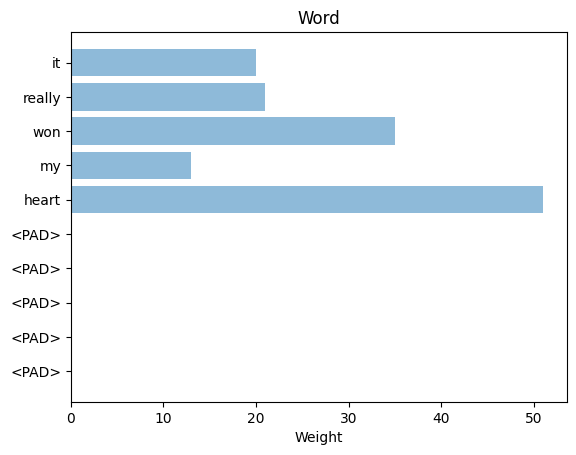



Average length of explanation: 4.85
Input image (ground truth = 1 It's a good review.):
Prediction: 1 (good review)
['shows', 'just', 'enough', 'to', 'keep', 'us', 'on', 'our', 'toes']
Explanation for class 1 (good review):


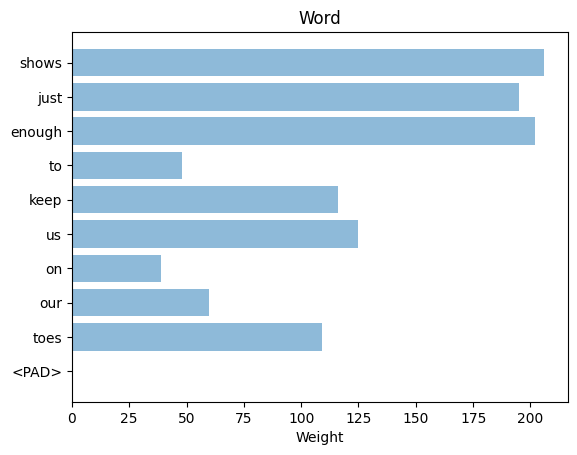



Average length of explanation: 1.46
Input image (ground truth = 1 It's a good review.):
Prediction: 1 (good review)
['a', 'hint', 'of', 'joy']
Explanation for class 1 (good review):


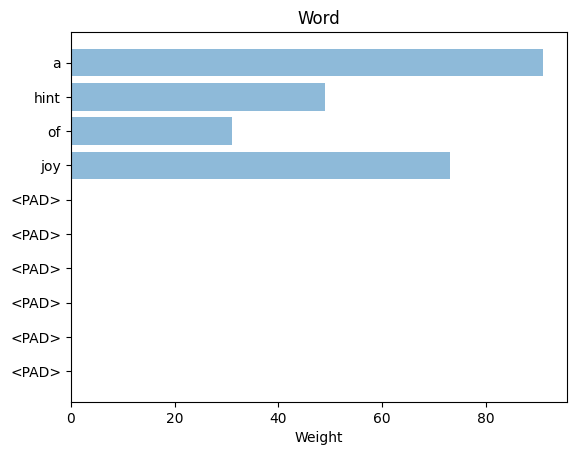



Average length of explanation: 5.12
Input image (ground truth = 1 It's a good review.):
Prediction: 1 (good review)
['his', 'work', 'transcends', 'the', 'boymeetsgirl', 'posturing', 'of', 'typical', 'love', 'stories']
Explanation for class 1 (good review):


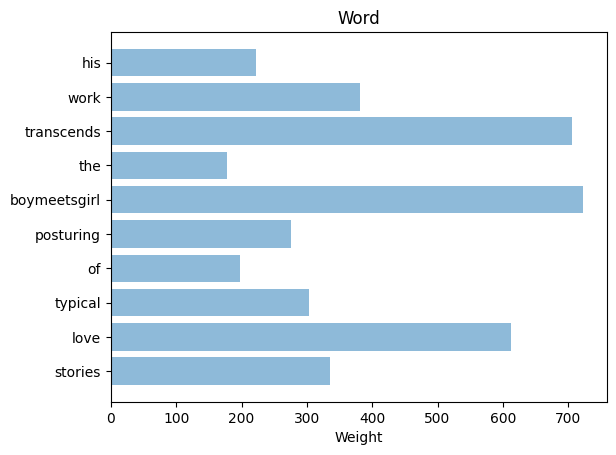



Average length of explanation: 5.44
Input image (ground truth = 1 It's a good review.):
Prediction: 1 (good review)
['firmly', 'believe', 'that', 'a', 'good', 'video', 'game', 'movie', 'is', 'going', 'to', 'show', 'up', 'soon']
Explanation for class 1 (good review):


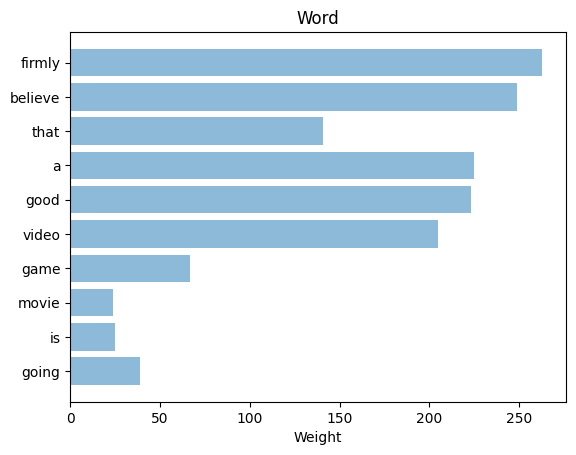



Average length of explanation: 6.2
Input image (ground truth = 1 It's a good review.):
Prediction: 1 (good review)
['makes', 'a', 'great', 'impression', 'as', 'the', 'writerdirector', 'of', 'this', 'little', '', '1']
Explanation for class 1 (good review):


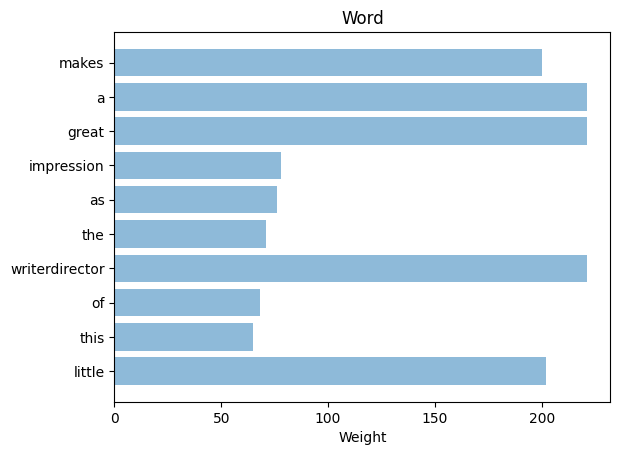



Average length of explanation: 4.84
Input image (ground truth = 1 It's a good review.):
Prediction: 1 (good review)
['more', 'satisfying', 'than', 'the', 'tearyeyed', 'original']
Explanation for class 1 (good review):


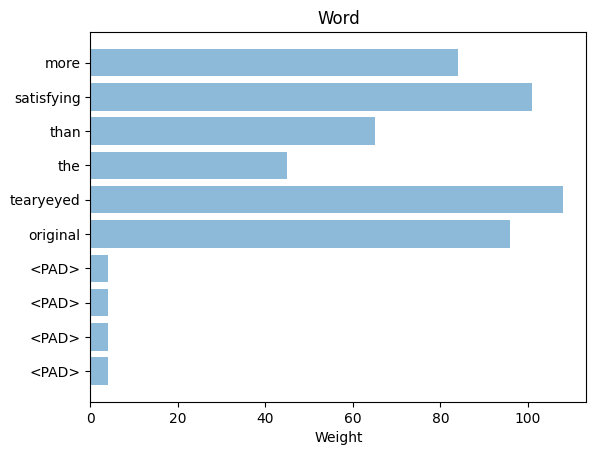



Average length of explanation: 3.5
Input image (ground truth = 1 It's a good review.):
Prediction: 1 (good review)
['has', 'more', 'than', 'enough', 'charm', 'to', 'make', 'it', 'memorable']
Explanation for class 1 (good review):


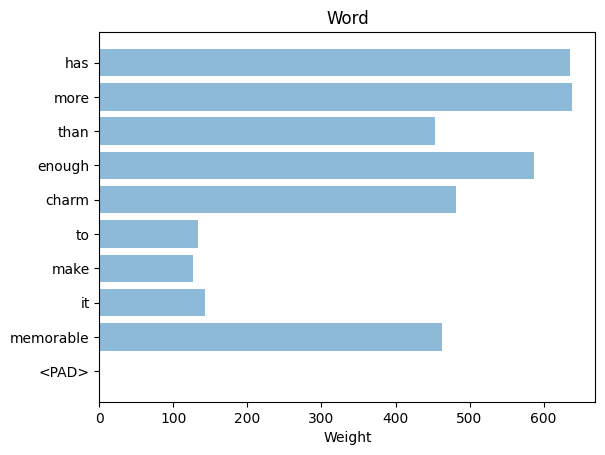

In [185]:
# for each file e_iteration
    # read in the dict
    # get the list of expls dict['expls']
    # remove the first one as its always a duplicate (I should fix this)
    # record length of min expl
    # for each expl for each word, just accumulate the count of that word
    
# calculate average length of minimum expl


idxs = [36911]
y_trues = [1]

for ii in range(len(idxs)):
    idx = idxs[ii]
    y_true = y_trues[ii]

    input_path = 'X_tmp.npy'
    output_path = f'exps/exps_idx{idx}_{y_true}'
    y_path = 'y_tmp.npy'


    one_exps = []
    zero_exps = []
    y_preds = []
    lengths = []
    one_count = 0
    zero_count = 0
    for f in os.listdir(output_path):
        if os.path.isfile(os.path.join(output_path,f)) and not f.startswith('X') and not f.startswith('y'):
            with open(os.path.join(output_path,f)) as file_h:
                tmp = json.load(file_h)
                
            if os.path.isfile(os.path.join(output_path,'y'+f+'.npy')):
                tmp_y = np.load(os.path.join(output_path,'y'+f+'.npy'))
                if tmp_y == 1:
                    one_exps += tmp['expls'][1:]
                    one_count += 1
                else:
                    zero_exps += tmp['expls'][1:]
                    zero_count += 1
                y_preds.append(tmp_y)
            else:
                if y_true == 1:
                    one_exps += tmp['expls'][1:]
                    one_count += 1
                else:
                    zero_exps += tmp['expls'][1:]
                    zero_count += 1
                y_preds.append(y_true)
                    
            lengths.append(len(tmp['expls'][1]))

            
    print("Average length of explanation:",np.mean(lengths))
    
    pred = scipy.stats.mode(y_preds)[0][0]
    
    act_class = "It's a good review." if y_true > 0 else "It's a bad review."
    pred_class = "(good review)" if pred > 0 else "(bad review)"
    print(f'Input image (ground truth = {y_true} {act_class}):')
    print(f'Prediction: {pred} {pred_class}')

    print(text_train[idx])
    
    #one_exps = [o/len(one_exps) for o in one_exps]
    #zero_exps = [z/len(zero_exps) for z in zero_exps]

    print(f'Explanation for class {pred} {pred_class}:')
    if pred == 1:
        one_exps = [j for sub in one_exps for j in sub]
        print_exp(one_exps,text_train[idx],maxlen,one_count)
    else:
        zero_exps = [j for sub in zero_exps for j in sub]
        print_exp(zero_exps,text_train[idx],maxlen,zero_count)
        
    opp = 1 if pred == 0 else 0
    opp_class = "(good review)" if pred == 0 else "(bad review)"
    if opp == 1:
        one_exps = [j for sub in one_exps for j in sub]
        if len(one_exps) > 0:
            print(f'Explanation for class {opp} {opp_class}:')
            print_exp(one_exps,text_train[idx],maxlen,one_count)
    else:
        zero_exps = [j for sub in zero_exps for j in sub]
        if len(zero_exps) > 0:
            print(f'Explanation for class {opp} {opp_class}:')
            print_exp(zero_exps,text_train[idx],maxlen,zero_count)
            
    print()
    print('=============================================================================')
    print()


# Misclassified example test runs

In [194]:
N = 50

while True:
    # pick a random input
    n = np.random.choice(list(range(len(X_train))))
    X = X_train[n].reshape(1,*X_train[n].shape)
    y_hat = np.argmax(bayes_model.predict(X,n=N))
    y_class = 'Positive.' if y_hat == 1 else 'Negative.'
    y_true_text = 'Positive.' if y_train[n] == 1 else 'Negative.'
    input_shape = X.flatten().shape
    if not y_hat == y_train[n]:
        break
        
print(n)
print(text_train[n])
print('Prediction:',y_class,'Ground truth:',y_true_text)

15431
['forget', 'about', 'one', 'oscar', 'nomination', 'for', 'julianne', 'moore', 'this', 'year']
Prediction: Positive. Ground truth: Negative.


In [195]:

input_path = 'X_tmp.npy'
y_path = 'y_act_tmp.npy'
X_text_path = 'X_text_tmp.json'
data = dict()
data['text'] = text_train[n]

output_path = f'exps/exps_idx{n}_{y_train[n]}'
if not os.path.exists(output_path):
    os.mkdir(output_path)
np.save(os.path.join(output_path,input_path),X.astype("float32"),False)
np.save(os.path.join(output_path,y_path),np.array(y_train[n]).astype("float32"),False)
with open(os.path.join(output_path,X_text_path),'w') as json_file:
    json.dump(data,json_file)
    
iterations = 50
for i in range(iterations):
    subprocess.Popen(['python3','get_ore_exp.py',str(i),model_name,os.path.join(output_path,input_path),os.path.join(output_path,X_text_path),output_path,'10','5','200'])

full = False 
while not full:
    if len([name for name in os.listdir(output_path) if os.path.isfile(os.path.join(output_path, name))]) >= ((2*iterations)+3):
        full = True

Average length of explanation: 8.04
Input image (ground truth = 1 It's a good review.):
Prediction: 0 (bad review)
['the', 'plot', 'of', 'the', 'comeback', 'curlers', 'isnt', 'very', 'interesting', 'actually', '', 'but', 'what', 'i', 'like', 'about', 'men', 'with', 'brooms', 'and', 'what', 'is', 'kind', 'of', 'special', 'is', 'how', 'the', 'film', 'knows', 'whats', 'unique', 'and', 'quirky', 'about', 'canadians']
Explanation for class 0 (bad review):


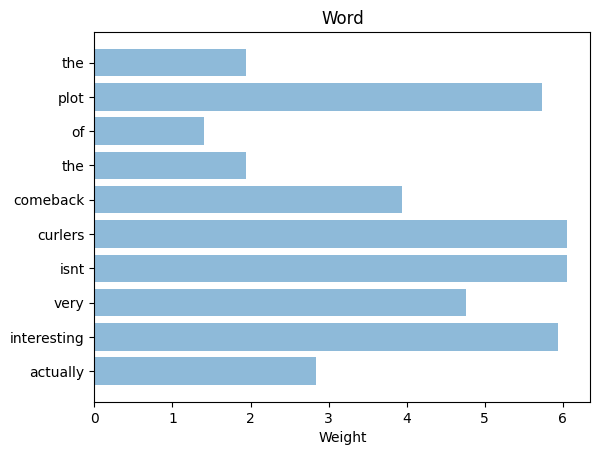

Explanation for class 1 (good review):


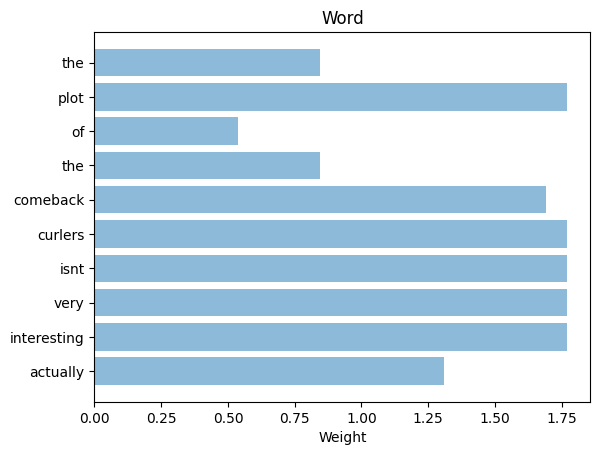



Average length of explanation: 8.3
Input image (ground truth = 0 It's a bad review.):
Prediction: 1 (good review)
['sweet', 'home', 'alabama', 'is', 'one', 'dumb', 'movie']
Explanation for class 1 (good review):


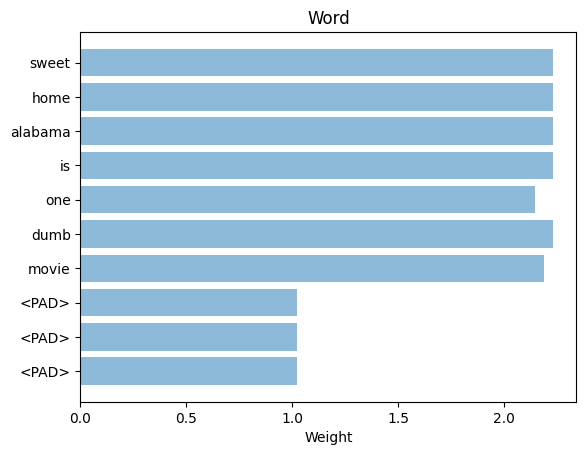

Explanation for class 0 (bad review):


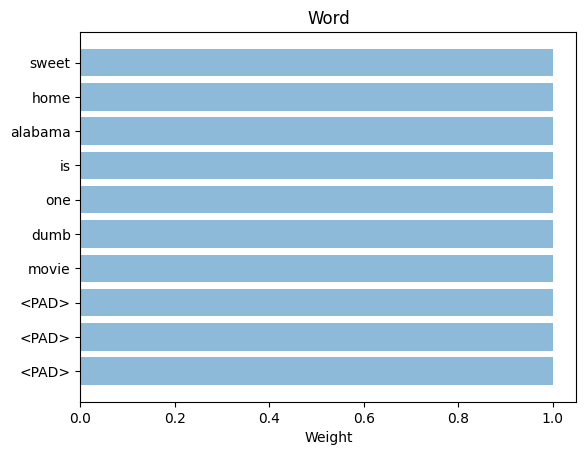



Average length of explanation: 4.46
Input image (ground truth = 0 It's a bad review.):
Prediction: 1 (good review)
['its', 'digs', 'at', 'modern', 'society', 'are', 'all', 'things', 'weve', 'seen', 'before']
Explanation for class 1 (good review):


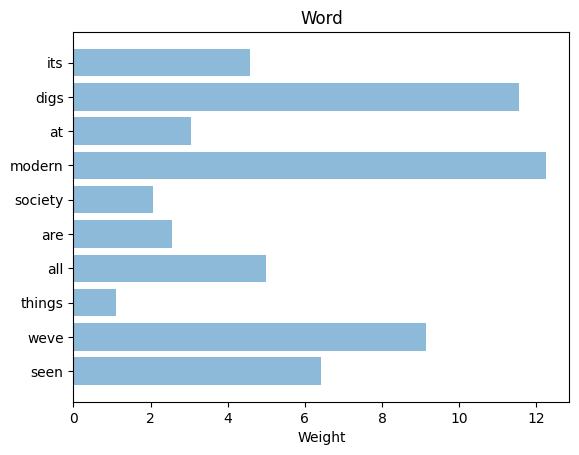



Average length of explanation: 4.98
Input image (ground truth = 0 It's a bad review.):
Prediction: 1 (good review)
['forget', 'about', 'one', 'oscar', 'nomination', 'for', 'julianne', 'moore', 'this', 'year']
Explanation for class 1 (good review):


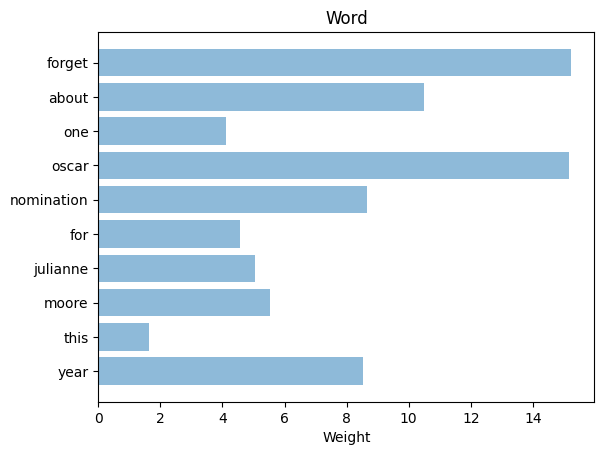

In [242]:
idxs = [26967,24610,73620,15431]
y_trues = [1,0,0,0]

for ii in range(len(idxs)):
    idx = idxs[ii]
    y_true = y_trues[ii]

    input_path = 'X_tmp.npy'
    output_path = f'exps/exps_idx{idx}_{y_true}'
    y_path = 'y_tmp.npy'


    one_exps = []
    zero_exps = []
    y_preds = []
    lengths = []
    one_count = 0
    zero_count = 0
    for f in os.listdir(output_path):
        if os.path.isfile(os.path.join(output_path,f)) and not f.startswith('X') and not f.startswith('y'):
            with open(os.path.join(output_path,f)) as file_h:
                tmp = json.load(file_h)
                
            if os.path.isfile(os.path.join(output_path,'y'+f+'.npy')):
                tmp_y = np.load(os.path.join(output_path,'y'+f+'.npy'))
                if tmp_y == 1:
                    one_exps += tmp['expls'][1:]
                    one_count += 1
                else:
                    zero_exps += tmp['expls'][1:]
                    zero_count += 1
                y_preds.append(tmp_y)
            else:
                if y_true == 1:
                    one_exps += tmp['expls'][1:]
                    one_count += 1
                else:
                    zero_exps += tmp['expls'][1:]
                    zero_count += 1
                y_preds.append(y_true)
                    
            lengths.append(len(tmp['expls'][1]))

            
    print("Average length of explanation:",np.mean(lengths))
    
    pred = scipy.stats.mode(y_preds)[0][0]
    
    act_class = "It's a good review." if y_true > 0 else "It's a bad review."
    pred_class = "(good review)" if pred > 0 else "(bad review)"
    print(f'Input image (ground truth = {y_true} {act_class}):')
    print(f'Prediction: {pred} {pred_class}')

    print(text_train[idx])
    
    #one_exps = [o/len(one_exps) for o in one_exps]
    #zero_exps = [z/len(zero_exps) for z in zero_exps]

    print(f'Explanation for class {pred} {pred_class}:')
    if pred == 1:
        one_exps = [j for sub in one_exps for j in sub]
        print_exp(one_exps,text_train[idx],maxlen,one_count)
    else:
        zero_exps = [j for sub in zero_exps for j in sub]
        print_exp(zero_exps,text_train[idx],maxlen,zero_count)
        
    opp = 1 if pred == 0 else 0
    opp_class = "(good review)" if pred == 0 else "(bad review)"
    if opp == 1:
        one_exps = [j for sub in one_exps for j in sub]
        if len(one_exps) > 0:
            print(f'Explanation for class {opp} {opp_class}:')
            print_exp(one_exps,text_train[idx],maxlen,one_count)
    else:
        zero_exps = [j for sub in zero_exps for j in sub]
        if len(zero_exps) > 0:
            print(f'Explanation for class {opp} {opp_class}:')
            print_exp(zero_exps,text_train[idx],maxlen,zero_count)
            
    print()
    print('=============================================================================')
    print()

# Highly uncertain test runs

In [222]:
N = 50

while True:
    # pick a random input
    n = np.random.choice(list(range(len(X_train))))
    X = X_train[n].reshape(1,*X_train[n].shape)
    ys = []
    for i in range(N):
        bayes_model.model.set_weights(bayes_model.sample())
        ys.append(bayes_model.model(X))
    ys = np.argmax(np.array(ys),axis=2).flatten()
    md = scipy.stats.mode(ys)[0]
    y_hat = md[0]
    y_class = 'Positive.' if y_hat == 1 else 'Negative.'
    y_true_text = 'Positive.' if y_train[n] == 1 else 'Negative.'
    input_shape = X.flatten().shape
    ys = list(ys)
    if ys.count(md) < int(len(ys)*0.75):
        break
    
print(n)
print(ys)
print(text_train[n])
print('Prediction:',y_class,'Ground truth:',y_true_text)

10575
[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
['ahnulds', 'action', 'hero', 'days', 'might', 'be', 'over']
Prediction: Positive. Ground truth: Negative.


In [223]:

input_path = 'X_tmp.npy'
y_path = 'y_act_tmp.npy'
X_text_path = 'X_text_tmp.json'
data = dict()
data['text'] = text_train[n]

output_path = f'exps/exps_idx{n}_{y_train[n]}'
if not os.path.exists(output_path):
    os.mkdir(output_path)
np.save(os.path.join(output_path,input_path),X.astype("float32"),False)
np.save(os.path.join(output_path,y_path),np.array(y_train[n]).astype("float32"),False)
with open(os.path.join(output_path,X_text_path),'w') as json_file:
    json.dump(data,json_file)
    
iterations = 50
for i in range(iterations):
    subprocess.Popen(['python3','get_ore_exp.py',str(i),model_name,os.path.join(output_path,input_path),os.path.join(output_path,X_text_path),output_path,'10','5','50'])

full = False 
while not full:
    if len([name for name in os.listdir(output_path) if os.path.isfile(os.path.join(output_path, name))]) >= ((2*iterations)+3):
        full = True

Average length of explanation: 7.88
Input image (ground truth = 1 It's a good review.):
Prediction: 0 (bad review)
['a', 'comingofage', 'film', 'that', 'avoids', 'the', 'cartoonish', 'clichés', 'and', 'sneering', 'humor', 'of', 'the', 'genre', 'as', 'it', 'provides', 'a', 'fresh', 'view', 'of', 'an', 'old', 'type']
Explanation for class 0 (bad review):


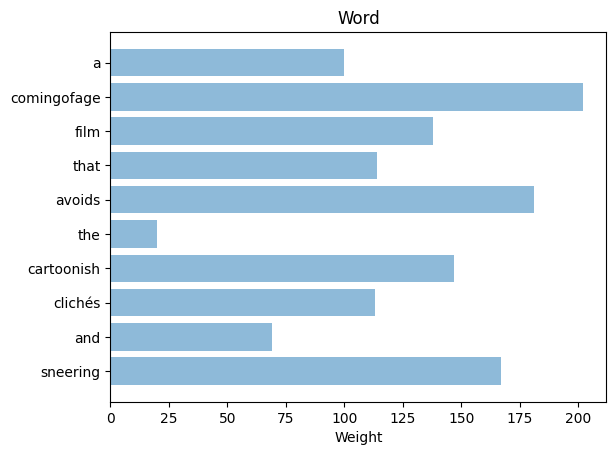

Explanation for class 1 (good review):


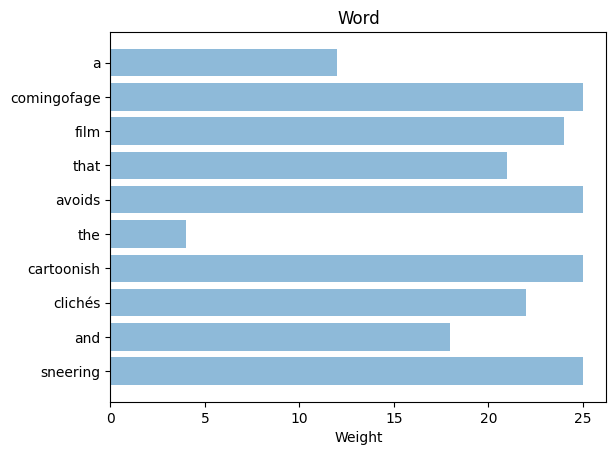



Average length of explanation: 7.18
Input image (ground truth = 0 It's a bad review.):
Prediction: 0 (bad review)
['less', 'charming', 'than', 'listening', 'to', 'a', 'fouryearold']
Explanation for class 0 (bad review):


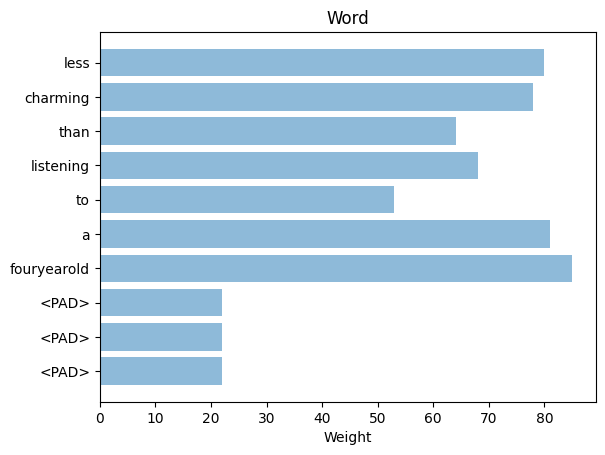

Explanation for class 1 (good review):


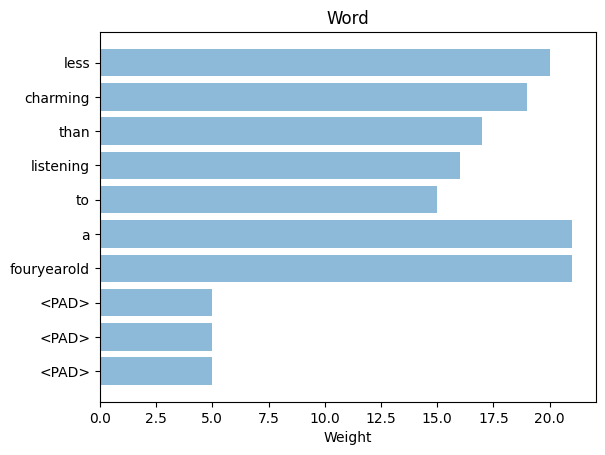



Average length of explanation: 6.44
Input image (ground truth = 0 It's a bad review.):
Prediction: 1 (good review)
['twodimensional', 'characters', 'who', 'are', 'anything', 'but', 'compelling']
Explanation for class 1 (good review):


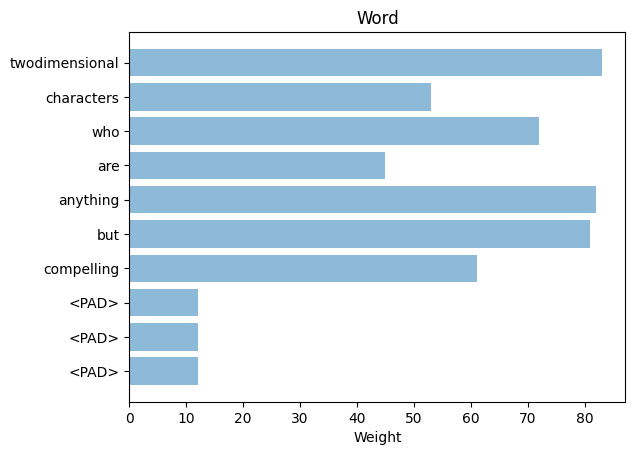

Explanation for class 0 (bad review):


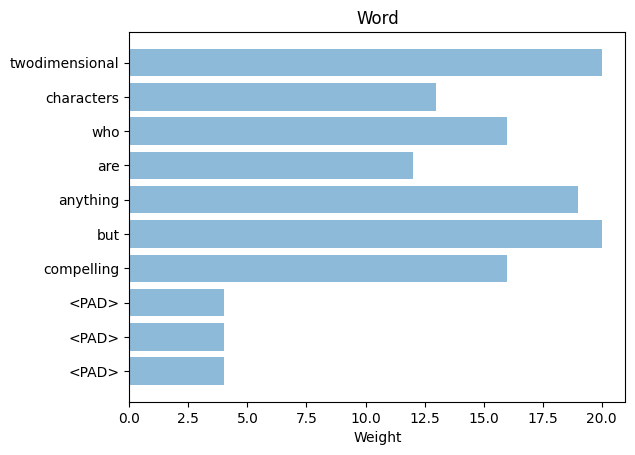



Average length of explanation: 7.72
Input image (ground truth = 0 It's a bad review.):
Prediction: 1 (good review)
['is', 'a', 'little', 'too', 'in', 'love', 'with', 'its', 'own', 'cuteness']
Explanation for class 1 (good review):


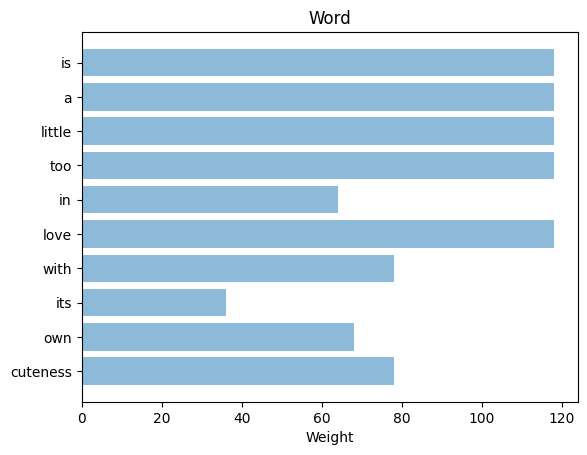

Explanation for class 0 (bad review):


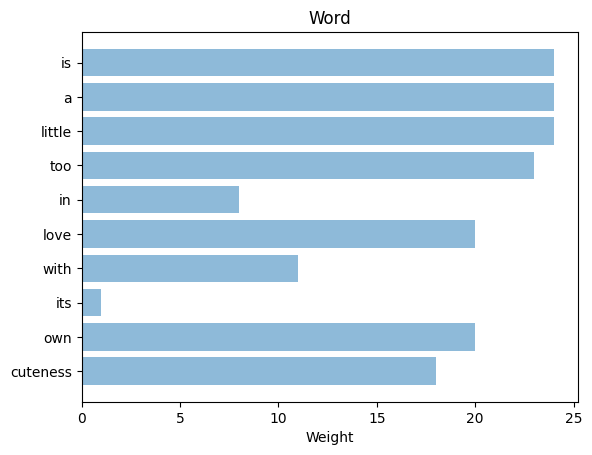



Average length of explanation: 7.42
Input image (ground truth = 0 It's a bad review.):
Prediction: 1 (good review)
['ahnulds', 'action', 'hero', 'days', 'might', 'be', 'over']
Explanation for class 1 (good review):


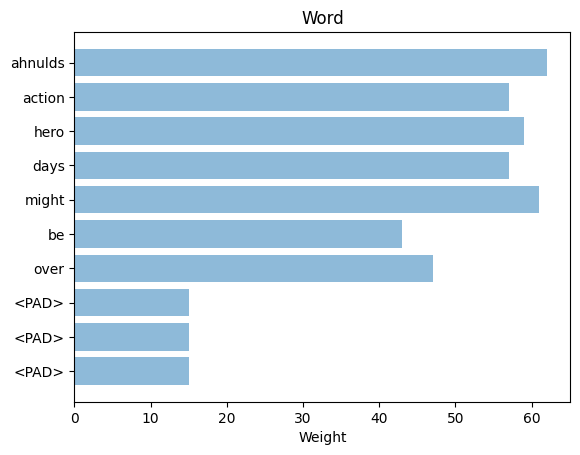

Explanation for class 0 (bad review):


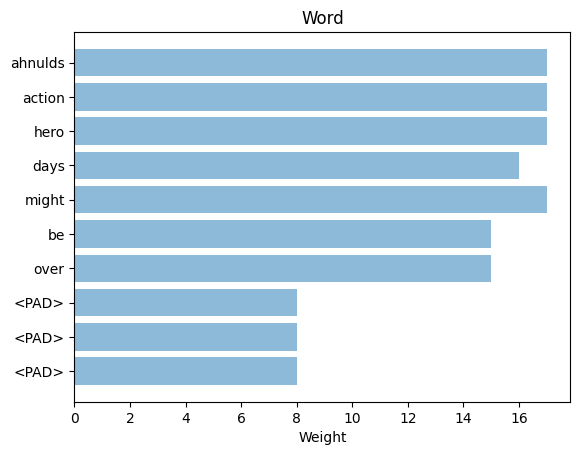

In [224]:
idxs = [8098,75671,110023,67697,10575]
y_trues = [1,0,0,0,0]

for ii in range(len(idxs)):
    idx = idxs[ii]
    y_true = y_trues[ii]

    input_path = 'X_tmp.npy'
    output_path = f'exps/exps_idx{idx}_{y_true}'
    y_path = 'y_tmp.npy'


    one_exps = []
    zero_exps = []
    y_preds = []
    lengths = []
    one_count = 0
    zero_count = 0
    for f in os.listdir(output_path):
        if os.path.isfile(os.path.join(output_path,f)) and not f.startswith('X') and not f.startswith('y'):
            with open(os.path.join(output_path,f)) as file_h:
                tmp = json.load(file_h)
                
            if os.path.isfile(os.path.join(output_path,'y'+f+'.npy')):
                tmp_y = np.load(os.path.join(output_path,'y'+f+'.npy'))
                if tmp_y == 1:
                    one_exps += tmp['expls'][1:]
                    one_count += 1
                else:
                    zero_exps += tmp['expls'][1:]
                    zero_count += 1
                y_preds.append(tmp_y)
            else:
                if y_true == 1:
                    one_exps += tmp['expls'][1:]
                    one_count += 1
                else:
                    zero_exps += tmp['expls'][1:]
                    zero_count += 1
                y_preds.append(y_true)
                    
            lengths.append(len(tmp['expls'][1]))

            
    print("Average length of explanation:",np.mean(lengths))
    
    pred = scipy.stats.mode(y_preds)[0][0]
    
    act_class = "It's a good review." if y_true > 0 else "It's a bad review."
    pred_class = "(good review)" if pred > 0 else "(bad review)"
    print(f'Input image (ground truth = {y_true} {act_class}):')
    print(f'Prediction: {pred} {pred_class}')

    print(text_train[idx])

    print(f'Explanation for class {pred} {pred_class}:')
    if pred == 1:
        one_exps = [j for sub in one_exps for j in sub]
        print_exp(one_exps,text_train[idx],maxlen,one_count)
    else:
        zero_exps = [j for sub in zero_exps for j in sub]
        print_exp(zero_exps,text_train[idx],maxlen,zero_count)
        
    opp = 1 if pred == 0 else 0
    opp_class = "(good review)" if pred == 0 else "(bad review)"
    if opp == 1:
        one_exps = [j for sub in one_exps for j in sub]
        if len(one_exps) > 0:
            print(f'Explanation for class {opp} {opp_class}:')
            print_exp(one_exps,text_train[idx],maxlen,one_count)
    else:
        zero_exps = [j for sub in zero_exps for j in sub]
        if len(zero_exps) > 0:
            print(f'Explanation for class {opp} {opp_class}:')
            print_exp(zero_exps,text_train[idx],maxlen,zero_count)
            
    print()
    print('=============================================================================')
    print()